# Predicting Doctor Appointment No-Shows
***

## Table of Contents
* [Introduction](#introduction)
* [Data Wrangling](#data_wrangling)
    * [General Properties](#general_properties)
    * [Data Cleaning](#data_cleaning)
        * [Checking for Duplicates](#cleaning_duplicates)
        * [Appointment ID](#cleaning_appointment_id)
        * [Scheduled Day](#cleaning_scheduled_day)
        * [Appointment Day](#cleaning_appointment_day)
        * [Gender](#cleaning_gender)
        * [Age](#cleaning_age)
        * [Bolsa Familia](#cleaning_bolsa_familia)
        * [Hypertension](#cleaning_hypertension)
        * [Diabetes](#cleaning_diabetes)
        * [Number of Handicaps](#cleaning_number_handicaps)
        * [SMS Received](#cleaning_sms_received)
        * [No Show](#cleaning_no_show)
        * [Neighborhood](#cleaning_neighborhood)
        * [Patient ID](#cleaning_patient_id)
            * [Patient ID Consistency](#cleaning_patient_id_consistency)
* [Feature Engineering and Additional Data](#feat_engineering)
* [Exploratory Data Analysis](#eda)

<a id='introduction'></a>

## Introduction
***

In this project, my aim is to determine what patient characteristics are connected with not showing up to a doctor's appointment by analyzing a data set of over 100K medical appointments in Vitória, Espírito Santo, Brazil provided by JoniHoppen on [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments).

<a id='data_wrangling'></a>

## Data Wrangling
***

In [1]:
import pandas as pd
import numpy as np
import geocoder
import matplotlib.pyplot as plt
import config
API_KEY = config.api_key

<a id='general_properties'></a>

### General Properties

In [2]:
df = pd.read_csv('KaggleV2-May-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
# Number of records
n = len(df)
n

110527

In [4]:
# Rename fields to have more consistent formatting and to English where appropriate
df.columns = ['PatientID', 'AppointmentID', 'Gender', 'ScheduledDay',
              'AppointmentDay', 'Age', 'Neighborhood', 'BolsaFamilia', \
              'Hypertension', 'Diabetes', 'Alcoholism', 'NumHandicaps', \
              'SMSReceived', 'NoShow']

In [5]:
# Number of nulls
df.isnull().sum()

PatientID         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighborhood      0
BolsaFamilia      0
Hypertension      0
Diabetes          0
Alcoholism        0
NumHandicaps      0
SMSReceived       0
NoShow            0
dtype: int64

> There are no null records in any of the fields

In [6]:
# Data types
df.dtypes

PatientID         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighborhood       object
BolsaFamilia        int64
Hypertension        int64
Diabetes            int64
Alcoholism          int64
NumHandicaps        int64
SMSReceived         int64
NoShow             object
dtype: object

<a id='data_cleaning'></a>

### Data Cleaning

<a id='cleaning_duplicates'></a>

#### Checking for Duplicates

In [7]:
df.duplicated(keep=False).any()

False

In [8]:
df.duplicated('AppointmentID', keep=False).any()

False

> There are no duplicate entries and no duplicate AppointmentIDs.

<a id='cleaning_appointment_id'></a>

#### Appointment ID

In [9]:
# All of the appointment IDs are 7 digits long, and are between these values
min_apptID = df['AppointmentID'].min()
max_apptID = df['AppointmentID'].max()
print('{} - {}'.format(min_apptID, max_apptID))

5030230 - 5790484


In [10]:
# AppointmentIDs are identifiers, so they are also converted to strings
df['AppointmentID'] = df['AppointmentID'].astype(str)

<a id='cleaning_scheduled_day'></a>

#### Scheduled Day
ScheduledDay represents the day that a patient created the appointment.

In [11]:
# Convert the scheduled day to a datetime
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])

# Verify that ScheduledDay is in a datetime format
df['ScheduledDay'].dtype

dtype('<M8[ns]')

In [12]:
# Check that the <M8[ns] is a datetime format
np.dtype('datetime64[ns]') == np.dtype('<M8[ns]')

True

In [13]:
# Verify that all records were converted to valid datetimes
np.isnat(df['ScheduledDay']).sum()

0

In [14]:
# The first date and time an appointment was scheduled 
np.min(df['ScheduledDay'])

Timestamp('2015-11-10 07:13:56')

In [15]:
# The last date and time an appointment was scheduled 
np.max(df['ScheduledDay'])

Timestamp('2016-06-08 20:07:23')

In [16]:
np.max(df['ScheduledDay']) - np.min(df['ScheduledDay'])

Timedelta('211 days 12:53:27')

> All appointments are created within an about 7-month time frame.

<a id='cleaning_appointment_day'></a>

#### Appointment Day
AppointmentDay is the day of the doctor's appointment.

In [17]:
# Convert the appointment day to a datetime
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

# Verify that AppointmentDay is in a datetime format
df['AppointmentDay'].dtype

dtype('<M8[ns]')

In [18]:
# Verify that all records were converted to valid datetimes
np.isnat(df['AppointmentDay']).sum()

0

In [19]:
# The first scheduled appointment
np.min(df['AppointmentDay'])

Timestamp('2016-04-29 00:00:00')

In [20]:
# The last scheduled appointment
np.max(df['AppointmentDay'])

Timestamp('2016-06-08 00:00:00')

In [21]:
np.max(df['AppointmentDay']) - np.min(df['AppointmentDay'])

Timedelta('40 days 00:00:00')

> While the appointments were scheduled during a 7-month period, they all were scheduled for a 40-day period.

<a id='cleaning_gender'></a>

#### Gender

In [22]:
# Gender data is clean
df['Gender'].value_counts()

F    71840
M    38687
Name: Gender, dtype: int64

In [23]:
# Encode gender as binary, 0 = male, 1 = female 
df['Gender'] = np.where(df['Gender'].values == 'F', 1, 0)
df['Gender'].value_counts()

1    71840
0    38687
Name: Gender, dtype: int64

<a id='cleaning_age'></a>

#### Age

In [24]:
age_counts = df['Age'].value_counts()
age_counts.index.sort_values()

Int64Index([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,
            ...
             93,  94,  95,  96,  97,  98,  99, 100, 102, 115],
           dtype='int64', length=104)

In [25]:
# Drop the record with an age of -1
invalid_age = df[df['Age'] == -1]['PatientID']
df.drop(invalid_age.index, inplace=True)

> I removed the record with the age of -1.  All of the other ages are plausible; although the age of 115 is improbable, it is still possible.

<a id='cleaning_bolsa_familia'></a>

#### Bolsa Família

[Bolsa Família](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia) is a social welfare program in Brazil.  A value of 1 for this field means that the patient receives financial aid from the Brazilian government under this progrm.

In [26]:
# BolsaFamilia data is clean
df['BolsaFamilia'].value_counts()

0    99665
1    10861
Name: BolsaFamilia, dtype: int64

<a id='cleaning_hypertension'></a>

#### Hypertension

In [27]:
# Hypertension data is clean
df['Hypertension'].value_counts()

0    88725
1    21801
Name: Hypertension, dtype: int64

<a id='cleaning_diabetes'></a>

#### Diabetes

In [28]:
# Diabetes data is clean
df['Diabetes'].value_counts()

0    102583
1      7943
Name: Diabetes, dtype: int64

<a id='cleaning_alcoholism'></a>

#### Alcholism

In [29]:
# Alcoholism data is clean
df['Alcoholism'].value_counts()

0    107166
1      3360
Name: Alcoholism, dtype: int64

<a id='cleaning_number_handicaps'></a>

#### Number of Handicaps

In [30]:
# This represents the number of handicaps a person has (as defined by the publisher of the dataset)
# All people having between 0-4 handicaps seems reasonable
df['NumHandicaps'].value_counts()

0    108285
1      2042
2       183
3        13
4         3
Name: NumHandicaps, dtype: int64

<a id='cleaning_sms_received'></a>

#### SMS Received
This field indicates whether or not a patient was sent an appointment reminder by the facility in the form of a text message.

In [31]:
# SMS Received data is clean
df['SMSReceived'].value_counts()

0    75044
1    35482
Name: SMSReceived, dtype: int64

<a id='cleaning_no_show'></a>

#### No Show

A value of yes for NoShow means that the patient did not show up to their appointment (they were a 'no show').

In [32]:
df['NoShow'].value_counts()

No     88207
Yes    22319
Name: NoShow, dtype: int64

In [33]:
# Convert NoShow to zeros and ones
df['NoShow'] = np.where(df['NoShow'].values == 'Yes', 1, 0)
df['NoShow'].value_counts()

0    88207
1    22319
Name: NoShow, dtype: int64

<a id='cleaning_neighborhood'></a>

#### Neighborhood

The Neighborhood field has the neighborhood of the doctor's facility.

In [34]:
neighborhood_counts = df['Neighborhood'].value_counts()
neighborhood_counts[:11]

JARDIM CAMBURI       7717
MARIA ORTIZ          5805
RESISTÊNCIA          4431
JARDIM DA PENHA      3877
ITARARÉ              3514
CENTRO               3334
TABUAZEIRO           3132
SANTA MARTHA         3131
JESUS DE NAZARETH    2853
BONFIM               2773
SANTO ANTÔNIO        2746
Name: Neighborhood, dtype: int64

In [35]:
# Number of unique neighborhoods
df['Neighborhood'].nunique()

81

In [36]:
# Organize the neighborhoods into a dataframe
geo = pd.DataFrame(neighborhood_counts.index, columns = ['neighborhood'])
geo.head()

,neighborhood
0,JARDIM CAMBURI
1,MARIA ORTIZ
2,RESISTÊNCIA
3,JARDIM DA PENHA
4,ITARARÉ


In [37]:
# Geocode the neighborhood data
for i, row in geo.iterrows():
    # Use Bing    
    full_neighborhood = row.str.title() + ', Vitória, Espírito Santo, Brazil'
    result = geocoder.bing(full_neighborhood, key=API_KEY)
    
    geo.at[i, 'status'] = result.status
    geo.at[i, 'lat'] = result.lat
    geo.at[i, 'lng'] = result.lng
    geo.at[i, 'bing_neighborhood'] = result.neighborhood
    geo.at[i, 'city'] = result.city
    geo.at[i, 'state'] = result.state
    geo.at[i, 'country'] = result.country
    
    # If Bing returns None for neighborhood, use Google
    if geo.loc[i, 'bing_neighborhood'] is None:
        result = geocoder.google(full_neighborhood)
        
        geo.at[i, 'status'] = result.status
        geo.at[i, 'lat'] = result.lat
        geo.at[i, 'lng'] = result.lng
        
        if result.county == 'Vitória': # Google uses county when Bing uses city
            geo.at[i, 'city'] = result.county
        geo.at[i, 'state'] = result.state
        if result.country == 'BR':
            geo.at[i, 'country'] = 'Brazil'

In [38]:
geo.head()

,neighborhood,status,lat,lng,bing_neighborhood,city,state,country
0,JARDIM CAMBURI,OK,-20.265020,-40.264420,Jardim Camburi,Vitória,ES,Brazil
1,MARIA ORTIZ,OK,-20.258221,-40.297482,Maria Ortiz,Vitória,ES,Brazil
2,RESISTÊNCIA,OK,-20.270830,-40.320320,Resistência,Vitória,ES,Brazil
3,JARDIM DA PENHA,OK,-20.284531,-40.294998,Jardim da Penha,Vitória,ES,Brazil
4,ITARARÉ,OK,-20.295549,-40.305199,Itararé,Vitória,ES,Brazil


In [39]:
# Check that all the neighborhoods are unique
(geo['bing_neighborhood'].value_counts() == 1).all()

True

In [40]:
# Check that each neighborhood returns a unique location
not any(geo.duplicated(['lat', 'lng']))

False

In [41]:
# Verify that all of the locations are in Vitória, Espírito Santo, Brazil
print((geo['status'] == 'OK').all())
print((geo['city'] == 'Vitória').all())
print((geo['state'] == 'ES').all())
print((geo['country'] == 'Brazil').all())

False
True
False
True


<a id='cleaning_patient_id'></a>

#### Patient ID

In [42]:
# Convert patient ID to a string, as it is meant to be an identifier not a number
df['PatientID'] = df['PatientID'].astype(int).astype(str)

# All identifiers are 7-15 digits long, most have at least 10
lens = df['PatientID'].apply(len)
pd.value_counts(lens)

14    39372
13    28319
15    24918
12    12835
11     4002
10      920
9       136
8        18
5         3
6         2
7         1
Name: PatientID, dtype: int64

> Most of the patient IDs are at least 10 digits long.  There is no consistent length for this field, and it is unknown, and impossible to know, if some of these patient identifiers are flawed.  It is an identifier and does not need to be operated on or with, therefore none of these records will be removed.

<a id='cleaning_patient_id_consistency'></a>

##### PatientID Consistency

In [43]:
# Number of appointments per PatientID
appts_by_patient = df.groupby('PatientID')['AppointmentID'].count()
appts_by_patient.head()

PatientID
11111462625267     1
111124532532143    2
11114485119737     1
11116239871275     1
1111633122891      3
Name: AppointmentID, dtype: int64

There are multiple appointments for some patients, so I am checking that the information for each patient across the different appointments is the same.

In [44]:
# All have the same gender
unique_gender_vals = df.groupby('PatientID')['Gender'].nunique()
unique_gender_vals[unique_gender_vals > 1]

Series([], Name: Gender, dtype: int64)

In [45]:
# All have the same BolsaFamilia status
unique_bf_vals = df.groupby('PatientID')['BolsaFamilia'].nunique()
unique_bf_vals[unique_bf_vals > 1]

Series([], Name: BolsaFamilia, dtype: int64)

In [46]:
# All have the same value for Hypertension
unique_hypertension_vals = df.groupby('PatientID')['Hypertension'].nunique()
unique_hypertension_vals[unique_hypertension_vals > 1]

Series([], Name: Hypertension, dtype: int64)

In [47]:
# All have the same value for Diabetes
unique_diabetes_vals = df.groupby('PatientID')['Diabetes'].nunique()
unique_diabetes_vals[unique_diabetes_vals > 1]

Series([], Name: Diabetes, dtype: int64)

In [48]:
# All have the same value for Alcoholism
unique_alcoholism_vals = df.groupby('PatientID')['Alcoholism'].nunique()
unique_alcoholism_vals[unique_alcoholism_vals > 1]

Series([], Name: Alcoholism, dtype: int64)

In [49]:
# All have the same value for NumHandicaps
unique_handicaps_vals = df.groupby('PatientID')['NumHandicaps'].nunique()
unique_handicaps_vals[unique_handicaps_vals > 1]

Series([], Name: NumHandicaps, dtype: int64)

In [50]:
# All have the same value for Neighborhood - so patients kept the same doctor's office/hospital
unique_neighborhood_vals = df.groupby('PatientID')['Neighborhood'].nunique()
unique_neighborhood_vals[unique_neighborhood_vals > 1]

Series([], Name: Neighborhood, dtype: int64)

In [51]:
# Appointments occur with a 7-month period, so the entries for a patient's ages should be within a year of each other
unique_age_vals = df.groupby('PatientID')['Age'].nunique()
not_unique_age_vals = unique_age_vals[unique_age_vals > 1]

# Patients with more than one appointment, all have less than 2 values for age
not_unique_age_vals[not_unique_age_vals > 2]

Series([], Name: Age, dtype: int64)

In [52]:
# Get the information for the patients with more than one age
patients_multiple_ages = list(not_unique_age_vals.index)
multiple_ages_info = df[df['PatientID'].isin(patients_multiple_ages)].sort_values('PatientID')
multiple_ages_info.head()

,PatientID,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,BolsaFamilia,Hypertension,Diabetes,Alcoholism,NumHandicaps,SMSReceived,NoShow
3850,112114682124172,5490237,1,2016-03-18 14:26:03,2016-05-02,0,RESISTÊNCIA,0,0,0,0,0,1,1
110232,112114682124172,5676082,1,2016-05-09 14:56:13,2016-06-08,1,RESISTÊNCIA,0,0,0,0,0,1,1
10283,11238367556569,5723118,1,2016-05-20 07:58:35,2016-05-20,29,ROMÃO,0,1,0,0,0,0,0
19089,11238367556569,5675794,1,2016-05-09 14:21:41,2016-05-13,28,ROMÃO,0,1,0,0,0,0,0
19091,11238367556569,5675795,1,2016-05-09 14:21:41,2016-05-13,28,ROMÃO,0,1,0,0,0,0,0


In [53]:
# Get the difference between each patient's ages
max_age = multiple_ages_info.groupby('PatientID')['Age'].max()
min_age = multiple_ages_info.groupby('PatientID')['Age'].min()
age_diff = max_age - min_age
age_diff.head()

PatientID
112114682124172    1
11238367556569     1
1124242331227      1
1126541547466      1
112777857389857    1
Name: Age, dtype: int64

In [54]:
# Each patient's ages are within one year of each other
age_diff[age_diff <= 1].all()

True

<a id='feat_engineering'></a>

## Feature Engineering and Additional Data
***

### Weather

I obtained weather data for Vitória airport from wunderground.com for the appointment dates.

In [105]:
xlsx = pd.ExcelFile('vitoria_weather.xlsx')
weather = pd.read_excel(xlsx, 'Sheet1', skiprows = 2)
weather['Date'] = pd.to_datetime(weather['Date']).dt.date
weather.head()

,Date,temp_high,temp_avg,temp_low,humidity_high,humidity_avg,humidity_low,visibility_high,visibility_avg,visibility_low,wind_high,wind_avg,precip_in,rain,thunderstorm,fog
0,2016-04-29,75,73,71,88,76,64,12,7,6,16,11,0.01,0,0,0
1,2016-04-30,80,74,69,88,79,70,12,7,6,13,7,0.00,0,0,0
2,2016-05-01,77,73,69,83,67,52,12,6,4,17,13,0.00,1,0,0
3,2016-05-02,81,74,66,83,58,33,12,8,6,17,11,0.00,0,0,0
4,2016-05-03,79,70,62,88,80,61,12,7,6,17,5,0.00,0,0,0


In [116]:
all(df['visibility_high'] == 12)

True

In [117]:
# Remove the visibility_high field since it has the same value for every date
df.drop('visibility_high', axis=1, inplace=True)

In [125]:
df = pd.merge(df, weather, left_on='AppointmentDay', right_on='Date', how='left')

In [124]:
# There are no null values
all(df.isnull().sum() == 0)

True

### Differences Between Scheduled and Appointment Days

In [55]:
# Add a field for the number of days between scheduling and the appointment
df['AppointmentDay'] = (df['AppointmentDay']).dt.date
df['ScheduledDayDay'] = (df['ScheduledDay']).dt.date
df['DayDiff'] = ((df['AppointmentDay'] - df['ScheduledDayDay'])/np.timedelta64(1, 'D')).astype(int)
df[['ScheduledDayDay', 'AppointmentDay', 'DayDiff']].head(10)

,ScheduledDayDay,AppointmentDay,DayDiff
0,2016-04-29,2016-04-29,0
1,2016-04-29,2016-04-29,0
2,2016-04-29,2016-04-29,0
3,2016-04-29,2016-04-29,0
4,2016-04-29,2016-04-29,0
5,2016-04-27,2016-04-29,2
6,2016-04-27,2016-04-29,2
7,2016-04-27,2016-04-29,2
8,2016-04-29,2016-04-29,0
9,2016-04-27,2016-04-29,2


### Day of Week and Weekend

In [76]:
# Add a field for whether the AppointmentDay is during the weekend (1) or not (0)
df['Weekend'] = (df['AppointmentDay']).dt.day

df['Day_of_Week'] = pd.to_datetime(df['AppointmentDay']).dt.dayofweek
df['Weekend'] = np.where(pd.to_datetime(df['AppointmentDay']).dt.dayofweek >= 5, 1, 0)

In [83]:
df['Weekend'].sum()

39

<a id='eda'></a>

## Exploratory Data Analysis
***

### Class Label Breakdown

In [57]:
# Count of labels
df.groupby('NoShow')['NoShow'].count()

NoShow
0    88207
1    22319
Name: NoShow, dtype: int64

In [58]:
# Proportion of labels
df.groupby('NoShow')['NoShow'].count()/n

NoShow
0    0.798058
1    0.201933
Name: NoShow, dtype: float64

### Correlation between variables

In [118]:
df.corr()

,Gender,Age,BolsaFamilia,Hypertension,Diabetes,Alcoholism,NumHandicaps,SMSReceived,NoShow,DayDiff,...,humidity_avg,humidity_low,visibility_avg,visibility_low,wind_high,wind_avg,precip_in,rain,thunderstorm,fog
Gender,1.000000,0.106452,0.114296,0.055722,0.032556,-0.106166,-0.022813,0.046302,0.004122,0.028411,...,0.003414,0.003266,-0.002897,-0.002306,0.006072,0.003306,-0.003270,0.000160,-0.002198,0.001648
Age,0.106452,1.000000,-0.092463,0.504586,0.292391,0.095810,0.078032,0.012633,-0.060327,0.034811,...,0.001476,-0.000552,0.003137,0.004217,-0.009753,-0.007812,-0.004378,-0.003969,0.003826,0.006267
BolsaFamilia,0.114296,-0.092463,1.000000,-0.019730,-0.024894,0.035022,-0.008587,0.001192,0.029134,-0.030423,...,-0.001823,-0.002832,0.000481,0.001595,0.005123,-0.000254,0.000042,0.000945,-0.000609,0.002130
Hypertension,0.055722,0.504586,-0.019730,1.000000,0.433085,0.087970,0.080083,-0.006270,-0.035704,-0.017218,...,-0.004333,-0.001843,-0.000086,0.005030,-0.002663,-0.003106,-0.001275,-0.003582,-0.000102,0.005065
Diabetes,0.032556,0.292391,-0.024894,0.433085,1.000000,0.018473,0.057530,-0.014552,-0.015181,-0.027190,...,-0.000748,0.002562,-0.001931,0.000861,-0.000582,0.000292,-0.001512,-0.000743,-0.000075,-0.001364
Alcoholism,-0.106166,0.095810,0.035022,0.087970,0.018473,1.000000,0.004647,-0.026149,-0.000197,-0.038520,...,-0.001072,-0.000886,0.000624,0.001194,-0.008011,-0.001733,-0.000256,0.006922,-0.001414,0.000251
NumHandicaps,-0.022813,0.078032,-0.008587,0.080083,0.057530,0.004647,1.000000,-0.024162,-0.006077,-0.019844,...,0.000019,0.004065,-0.001778,0.000442,-0.000472,0.003834,-0.000940,-0.001154,-0.001666,-0.001800
SMSReceived,0.046302,0.012633,0.001192,-0.006270,-0.014552,-0.026149,-0.024162,1.000000,0.126428,0.398143,...,-0.083565,-0.102985,0.028104,-0.028857,0.127514,0.019436,0.001409,-0.039460,0.032427,0.082908
NoShow,0.004122,-0.060327,0.029134,-0.035704,-0.015181,-0.000197,-0.006077,0.126428,1.000000,0.186228,...,-0.010622,-0.008422,0.005194,0.007781,0.001550,0.003531,-0.004856,-0.003870,-0.011599,-0.011341
DayDiff,0.028411,0.034811,-0.030423,-0.017218,-0.027190,-0.038520,-0.019844,0.398143,0.186228,1.000000,...,0.016787,-0.000350,0.004529,-0.015857,-0.018070,-0.012200,-0.011022,-0.005197,-0.004347,0.037534


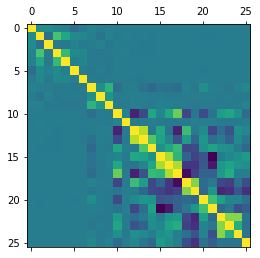

In [119]:
plt.matshow(df.corr());

> The strongest correlations are between age, hypertension, and diabetes (pair-wise between the three).  The variables that have the strongest correlation with being a no-show is SMSReceived at 0.126428 and DayDiff at 0.186228.  DayDiff is also strongly correlated with SMSReceived at 0.398143.  All other relationships less than half as strong as this correlation.

### No Shows by Gender

In [61]:
# Count
df.groupby(['Gender','NoShow'])['NoShow'].count()

Gender  NoShow
0       0         30962
        1          7725
1       0         57245
        1         14594
Name: NoShow, dtype: int64

In [62]:
# Proportion
df.groupby(['Gender','NoShow'])['NoShow'].count()/df.groupby('Gender')['NoShow'].count()

Gender  NoShow
0       0         0.800321
        1         0.199679
1       0         0.796851
        1         0.203149
Name: NoShow, dtype: float64

There are far more female patients than male patients, but they are both  just as likely to skip out on an appointment.

### No Shows by Neighborhood

In [63]:
# Count
df.groupby(['Neighborhood','NoShow'])['NoShow'].count()

Neighborhood         NoShow
AEROPORTO            0            7
                     1            1
ANDORINHAS           0         1741
                     1          521
ANTÔNIO HONÓRIO      0          221
                     1           50
ARIOVALDO FAVALESSA  0          220
                     1           62
BARRO VERMELHO       0          332
                     1           91
BELA VISTA           0         1523
                     1          384
BENTO FERREIRA       0          665
                     1          193
BOA VISTA            0          254
                     1           58
BONFIM               0         2223
                     1          550
CARATOÍRA            0         1974
                     1          591
CENTRO               0         2631
                     1          703
COMDUSA              0          254
                     1           56
CONQUISTA            0          689
                     1          160
CONSOLAÇÃO           0         1139
